In [1]:
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI,OpenAIEmbeddings #this to above classes we used to interact with llm model.
from dotenv import load_dotenv
from langgraph.graph import StateGraph,END,START #this class we used to build stateful workflows in graphical form mei.
from pydantic import BaseModel,Field,computed_field
from typing import Annotated,List,Dict,TypedDict,Optional

load_dotenv()

True

# step:1) defining LLM model Object

In [2]:
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint

#first we have to define kon se HuggingFaceEndpoint pe API Request jayeghi
# Hugging Face endpoint define karo
llm = HuggingFaceEndpoint(
    repo_id="mistralai/Mistral-7B-Instruct-v0.3",
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
)

# Chat model object banao
model1 = ChatHuggingFace(llm=llm)
model2 = ChatOpenAI(temperature=0.2)

# step:2) defining state or memory class using pydantic and creating graphstate object

In [3]:
class BatsmanState(BaseModel):
    runs: int = Field(...,description="Total run score by batsman per inning")
    balls : int = Field(...,description="Total balls played by batsman per inning")
    fours: int = Field(...,description="Total fours played by batsman per inning")
    sixes : int = Field(...,description="Total sixes played by batsman per inning")
      
    #calculated fields.  
    strikerate: Optional[float] = Field(None,description="Total strike rate of  batsman per inning")
    ball_per_boundary: Optional[float] = Field(None,description="Total ball per boundary of  batsman per inning")
    boundary_percentage:Optional[float] = Field(None,description="Total boundary percentage rate of  batsman per inning")
    summary:Optional[str] = Field(None,description="Describe the summary about batsman per inning")

In [4]:
#creating state graph object by using StateGraph class
graph = StateGraph(BatsmanState)
graph

# step:3) adding nodes and edges to graph

```
LangGraph ke parallel workflow (ya sequential bhi), by default har node me agar tum sirf ek field return karte ho, to woh poore state object overwrite nahi hota. Sirf wahi field update hota hai jo return kiya gaya hai.

this thing we have to take care refer below node function mei example
```

In [5]:
#creating strikeRate nodes ke liye user defined function.
#below function is also be a reducer function means function take state as parameter and update the state and rtn it.
def strikeRate(state:BatsmanState) -> BatsmanState:
    #fetching the field from state class.
    total_run = state.runs
    total_ball = state.balls
    
    #formula to calculate strikerate
    strikerate_caln =  (total_run / total_ball) * 100
    
    #update the strikerate field in state Memory mein.
    strikerate = strikerate_caln
    
    #returning the updated state.
    return {'strikerate':strikerate} #this we called as partial update in state memory.

In [6]:
#creating boundaryPercentage node ke liye user define function.
def boundaryPercentage(state:BatsmanState) -> BatsmanState:
    #fetching the fields from BatsmanState class.
    total_sixes = state.sixes
    total_fours = state.fours
    total_balls = state.balls
    
    num_caln = (total_fours * 4) + (total_sixes * 6) 
    
    boun_perc = (num_caln)/(total_balls)*100
    
    #Only update the boundary_percentage field in state Memory mein.
    boundary_percentage = boun_perc
    return {'boundary_percentage':boundary_percentage}

In [7]:
#creating BallPerBoundary nodes ke liye user defined function.
def BallPerBoundary(state:BatsmanState) ->BatsmanState:
    #fetching the field from state object.
    total_balls = state.balls
    no_of_boundary_hit = state.fours
    
    bpb = (total_balls/no_of_boundary_hit)*100
    
    #updating the ball_per_boundary field in memory state.
    ball_per_boundary = bpb
    
    return {'ball_per_boundary':ball_per_boundary}

In [8]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

#creating object of StrOutputParser class
parser = StrOutputParser()

#creating summary nodes ke liye user defined function.
def summary(state:BatsmanState) ->BatsmanState:
    #fetching field from stae object.
    boundary_percentage = state.boundary_percentage
    strikerate = state.strikerate
    bpb = state.ball_per_boundary
    
    #creating a structure instruction template prompt
    
    player_summary_prompt = PromptTemplate(
    template="""
    You are a cricket analyst.

    Based on the following performance statistics, provide a concise and clear summary
    of the player's batting performance in this inning:

    - Strike Rate: {strikerate}
    - Boundary Percentage: {boundary_percentage}%
    - Balls per Boundary: {ball_per_boundary}

    Please highlight what these numbers indicate about the player's batting style 
    (e.g., aggressive, balanced, defensive).
    """,
    input_variables=["strikerate", "boundary_percentage", "ball_per_boundary"]
    )
    
    #creating chain to perform action
    chain = player_summary_prompt | model2 | parser
    
    #invoking the chain
    summary = chain.invoke({"strikerate":strikerate,"boundary_percentage":boundary_percentage,"ball_per_boundary":bpb})
    
    #updating the summary field only in state memory 

    return {'summary':summary} 

In [9]:
#Nodes in LangGraph are simply user-defined Python functions that perform specific tasks.

#adding nodes to graph
graph.add_node(node='strikeRate',action=strikeRate)
graph.add_node(node='boundaryPercentage',action=boundaryPercentage)
graph.add_node(node='BallPerBoundary',action=BallPerBoundary)
graph.add_node(node='summary',action=summary)


In [10]:
#adding the edges to graph that connect the node1 from node2...so on or we can set the loop or condition in edges.
graph.add_edge(START,'strikeRate')
graph.add_edge(START,'boundaryPercentage')
graph.add_edge(START,'BallPerBoundary')


graph.add_edge('strikeRate','summary')   
graph.add_edge('boundaryPercentage','summary')  
graph.add_edge('BallPerBoundary','summary')  
graph.add_edge('summary',END)  


# step:4) compiling the graph

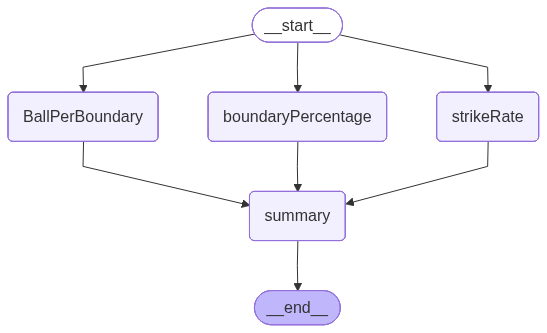

In [11]:
#now compiling the graph
graph.compile()

# step:5) executing the graph

In [12]:
workflow = graph.compile()

#defining initial state 
initial_state = BatsmanState(
    runs=100,
    balls=50,
    fours=6,
    sixes=4
    )

In [13]:
#exceuting the graph.
result = workflow.invoke(initial_state)
result

{'runs': 100,
 'balls': 50,
 'fours': 6,
 'sixes': 4,
 'strikerate': 200.0,
 'ball_per_boundary': 833.3333333333334,
 'boundary_percentage': 96.0,
 'summary': "In this inning, the player displayed an extremely aggressive batting style. With a strike rate of 200.0, they were scoring runs at a rapid pace. The high boundary percentage of 96.0% indicates that the player was consistently hitting boundaries, showcasing their ability to find gaps and clear the ropes frequently. Additionally, the low balls per boundary ratio of 833.33 suggests that the player was able to score boundaries quickly without taking too many deliveries to do so. Overall, this player's performance was characterized by aggressive and attacking batting."}

In [15]:
print(result['summary'])

In this inning, the player displayed an extremely aggressive batting style. With a strike rate of 200.0, they were scoring runs at a rapid pace. The high boundary percentage of 96.0% indicates that the player was consistently hitting boundaries, showcasing their ability to find gaps and clear the ropes frequently. Additionally, the low balls per boundary ratio of 833.33 suggests that the player was able to score boundaries quickly without taking too many deliveries to do so. Overall, this player's performance was characterized by aggressive and attacking batting.
